# Masked Autoencoders Are Scalable Vision Learners

This notebook is a TF2 implementation of [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377) by He et. al.

The notebook uses the following resources as references:

- https://keras.io/examples/vision/image_classification_with_vision_transformer/

# Imports & Setup

In [1]:
# !pip install -q tensorflow-addons

In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
###### DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 512
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 72  # We'll resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extract from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.6

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 64
DEC_PROJECTION_DIM = 48
ENC_NUM_HEADS = 4
ENC_LAYERS = 2
DEC_NUM_HEADS = 4
DEC_LAYERS = 1 # The decoder is lightweight but should be reasonably deep for reconstruction.
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

# Dataset

Using CIFAR100 for our implementation.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

2021-11-18 16:08:30.238241: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 16:08:30.720651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38444 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Data Augmentation

In [6]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE + 30, IMAGE_SIZE + 30),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

# Create Patches

This layer creates patches from input images. The layer also consists of two utility methods:
- `show_patched_image`: This utility function takes a batch of images and its corresponding patches, randomly choses a pair and plots it. This is useful for a sanity check.
- `reconstruct_from_patch`: This utility funciton takes the patches of a **single** image, and reconstructs it back into the original image. This is useful for the training monitor callback defined later.

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(len(patches))
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(NUM_PATCHES))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        patch = tf.reshape(patch, (NUM_PATCHES, PATCH_SIZE, PATCH_SIZE, 3))
        rows = tf.split(patch, IMAGE_SIZE // PATCH_SIZE, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [8]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmeneted_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

Index selected: 102.


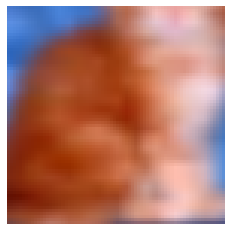

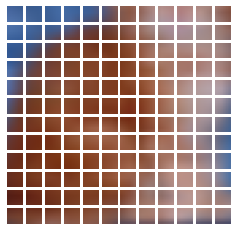

In [9]:
# Get the patches from the batched images.
patches = patch_layer(images=augmeneted_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmeneted_images, patches=patches)

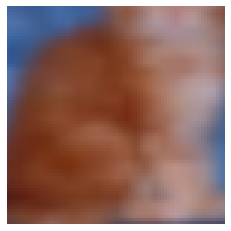

In [10]:
# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

# Patch Encoder

This layer deals with encoding the pathces and adding the positional embedding too. The layer holds two utility functions:
- `get_random_indices`: This function provides randomly sampled mask and unmask indices.
- `show_masked_image`: A utility function that plots a random masked image.

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        batch_size=BATCH_SIZE,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        self.batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [self.batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices()
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=self.batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
            )

    def get_random_indices(self):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(self.batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]

        return mask_indices, unmask_indices

    def show_masked_image(self, patches):
        # Utility function that helps visualize maksed images.
        _, unmask_indices = self.get_random_indices()
        unmasked_patches = tf.gather(patches, unmask_indices, axis=1, batch_dims=1)

        # Necessary for plotting.
        ids = tf.argsort(unmask_indices)
        sorted_unmask_indices = tf.sort(unmask_indices)
        unmasked_patches = tf.gather(unmasked_patches, ids, batch_dims=1)

        # Select a random index for visualization.
        idx = np.random.choice(len(sorted_unmask_indices))
        print(f"Index selected: {idx}.")

        n = int(np.sqrt(NUM_PATCHES))
        unmask_index = sorted_unmask_indices[idx]
        unmasked_patch = unmasked_patches[idx]

        plt.figure(figsize=(4, 4))

        count = 0
        for i in range(NUM_PATCHES):
            ax = plt.subplot(n, n, i + 1)

            if count < PATCH_SIZE * PATCH_SIZE and unmask_index[count].numpy() == i:
                patch = unmasked_patch[count]
                patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
                plt.imshow(keras.utils.img_to_array(patch_img))
                plt.axis("off")
                count = count + 1
            else:
                patch_img = tf.zeros((PATCH_SIZE, PATCH_SIZE, 3))
                plt.imshow(keras.utils.img_to_array(patch_img))
                plt.axis("off")
        plt.show()

        # Return the random index to validate the image outside the method.
        return idx

2021-11-18 16:08:37.420370: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Index selected: 435.


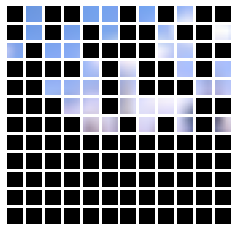

In [12]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
) = patch_encoder(patches=patches)

# Show a maksed patch image.
random_index = patch_encoder.show_masked_image(patches)

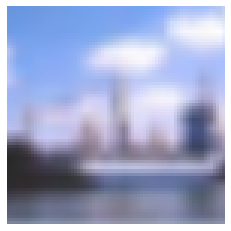

In [13]:
plt.imshow(augmeneted_images[random_index])
plt.axis("off")
plt.show()

# Multi-Layer Perceptron

In [14]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Encoder

In [15]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

# Decoder

In [16]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

# MaskedAutoEncoder Model

This is the trainer model where we encapsulate the training logic.

In [17]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmeneted_images = self.test_augmentation_model(images)
        else:
            augmeneted_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmeneted_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
        ) = self.patch_encoder(patches)
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

# Model instantiation

In [18]:
keras.backend.clear_session()

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

# Training callbacks

In [19]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))
test_aug_model = get_test_augmentation_model()
test_augmeneted_images = test_aug_model(test_images)


class TrainMonitor(tf.keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_patches = self.model.patch_layer(test_augmeneted_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                _,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Plot the images.
            idx = np.random.choice(len(test_patches))
            print(f"\nIndex selected: {idx}.")
            original = test_augmeneted_images[idx]
            reconstructed = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(tf.keras.preprocessing.image.array_to_img(original))
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(tf.keras.preprocessing.image.array_to_img(reconstructed))
            ax[1].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [20]:
timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")

train_callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_mae", factor=0.5, patience=3, verbose=1
    ),
    keras.callbacks.TensorBoard(log_dir=f"mae_logs_{timestamp}"),
    TrainMonitor(epoch_interval=5),
]

## Model compilation

In [21]:
optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

# Model training

Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 0.0511 - mae: 0.1789
Index selected: 348.


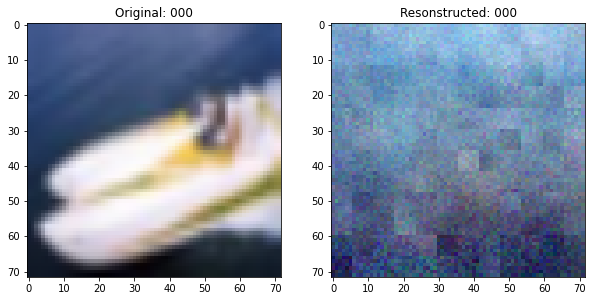

79/79 [==============================] - 10s 55ms/step - loss: 0.0510 - mae: 0.1789 - val_loss: 0.0442 - val_mae: 0.1683 - lr: 0.0010
Epoch 2/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0403 - mae: 0.1598 - val_loss: 0.0398 - val_mae: 0.1571 - lr: 0.0010
Epoch 3/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0359 - mae: 0.1492 - val_loss: 0.0364 - val_mae: 0.1494 - lr: 0.0010
Epoch 4/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0341 - mae: 0.1449 - val_loss: 0.0357 - val_mae: 0.1474 - lr: 0.0010
Epoch 5/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0311 - mae: 0.1372 - val_loss: 0.0319 - val_mae: 0.1368 - lr: 0.0010
Epoch 6/100
79/79 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.1257
Index selected: 270.


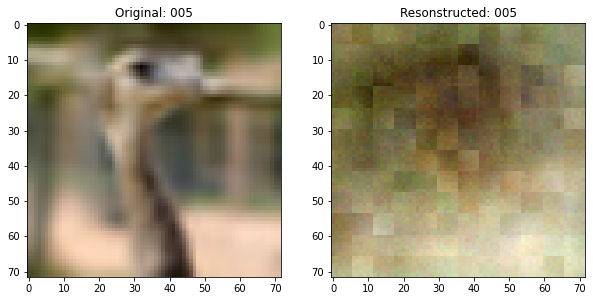

79/79 [==============================] - 4s 46ms/step - loss: 0.0269 - mae: 0.1257 - val_loss: 0.0287 - val_mae: 0.1296 - lr: 0.0010
Epoch 7/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0243 - mae: 0.1186 - val_loss: 0.0275 - val_mae: 0.1267 - lr: 0.0010
Epoch 8/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0221 - mae: 0.1123 - val_loss: 0.0237 - val_mae: 0.1152 - lr: 0.0010
Epoch 9/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0203 - mae: 0.1069 - val_loss: 0.0227 - val_mae: 0.1134 - lr: 0.0010
Epoch 10/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0194 - mae: 0.1040 - val_loss: 0.0221 - val_mae: 0.1108 - lr: 0.0010
Epoch 11/100
79/79 [==============================] - ETA: 0s - loss: 0.0185 - mae: 0.1014
Index selected: 106.


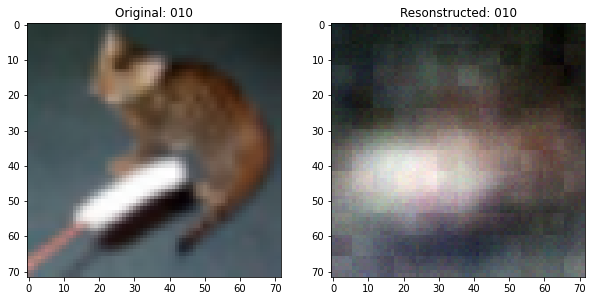

79/79 [==============================] - 4s 46ms/step - loss: 0.0185 - mae: 0.1014 - val_loss: 0.0212 - val_mae: 0.1085 - lr: 0.0010
Epoch 12/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0176 - mae: 0.0987 - val_loss: 0.0212 - val_mae: 0.1087 - lr: 0.0010
Epoch 13/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0172 - mae: 0.0975 - val_loss: 0.0204 - val_mae: 0.1055 - lr: 0.0010
Epoch 14/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0165 - mae: 0.0952 - val_loss: 0.0197 - val_mae: 0.1035 - lr: 0.0010
Epoch 15/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0161 - mae: 0.0940 - val_loss: 0.0194 - val_mae: 0.1036 - lr: 0.0010
Epoch 16/100
79/79 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0927
Index selected: 71.


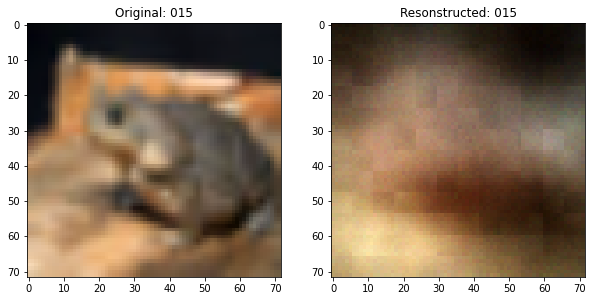

79/79 [==============================] - 4s 46ms/step - loss: 0.0157 - mae: 0.0927 - val_loss: 0.0190 - val_mae: 0.1024 - lr: 0.0010
Epoch 17/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0153 - mae: 0.0914 - val_loss: 0.0186 - val_mae: 0.0999 - lr: 0.0010
Epoch 18/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0149 - mae: 0.0903 - val_loss: 0.0178 - val_mae: 0.0984 - lr: 0.0010
Epoch 19/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0147 - mae: 0.0896 - val_loss: 0.0188 - val_mae: 0.1021 - lr: 0.0010
Epoch 20/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0145 - mae: 0.0891 - val_loss: 0.0177 - val_mae: 0.0984 - lr: 0.0010
Epoch 21/100
79/79 [==============================] - ETA: 0s - loss: 0.0141 - mae: 0.0875
Index selected: 188.


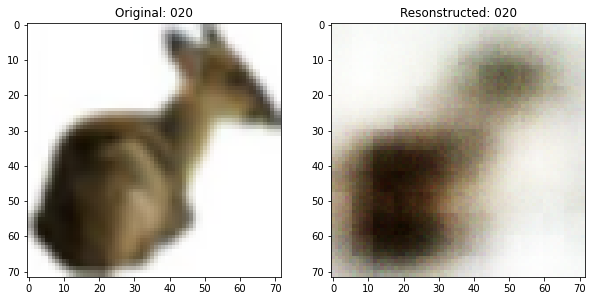

79/79 [==============================] - 4s 46ms/step - loss: 0.0141 - mae: 0.0875 - val_loss: 0.0173 - val_mae: 0.0963 - lr: 0.0010
Epoch 22/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0138 - mae: 0.0865 - val_loss: 0.0167 - val_mae: 0.0945 - lr: 0.0010
Epoch 23/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0134 - mae: 0.0852 - val_loss: 0.0165 - val_mae: 0.0940 - lr: 0.0010
Epoch 24/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0131 - mae: 0.0841 - val_loss: 0.0162 - val_mae: 0.0930 - lr: 0.0010
Epoch 25/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0129 - mae: 0.0836 - val_loss: 0.0159 - val_mae: 0.0923 - lr: 0.0010
Epoch 26/100
79/79 [==============================] - ETA: 0s - loss: 0.0126 - mae: 0.0827
Index selected: 20.


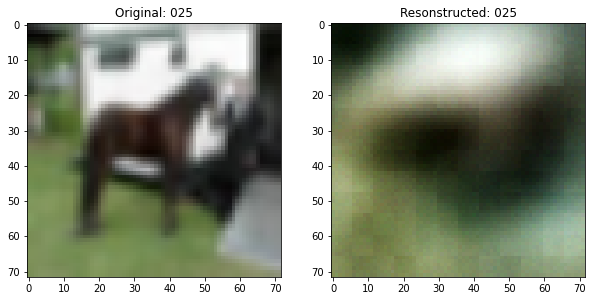

79/79 [==============================] - 4s 46ms/step - loss: 0.0126 - mae: 0.0827 - val_loss: 0.0159 - val_mae: 0.0915 - lr: 0.0010
Epoch 27/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0124 - mae: 0.0818 - val_loss: 0.0156 - val_mae: 0.0912 - lr: 0.0010
Epoch 28/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0122 - mae: 0.0812 - val_loss: 0.0154 - val_mae: 0.0900 - lr: 0.0010
Epoch 29/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0120 - mae: 0.0805 - val_loss: 0.0154 - val_mae: 0.0901 - lr: 0.0010
Epoch 30/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0119 - mae: 0.0799 - val_loss: 0.0154 - val_mae: 0.0912 - lr: 0.0010
Epoch 31/100
79/79 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0797
Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Index selected: 102.


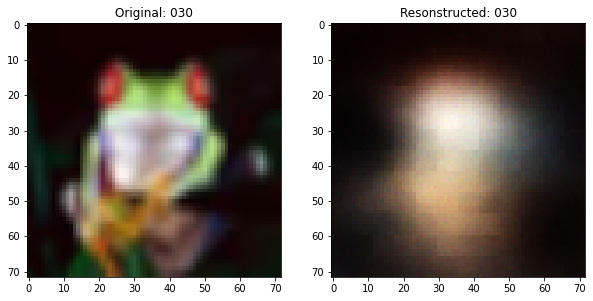

79/79 [==============================] - 4s 47ms/step - loss: 0.0118 - mae: 0.0797 - val_loss: 0.0152 - val_mae: 0.0905 - lr: 0.0010
Epoch 32/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0114 - mae: 0.0779 - val_loss: 0.0145 - val_mae: 0.0873 - lr: 5.0000e-04
Epoch 33/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0113 - mae: 0.0775 - val_loss: 0.0145 - val_mae: 0.0872 - lr: 5.0000e-04
Epoch 34/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0112 - mae: 0.0772 - val_loss: 0.0143 - val_mae: 0.0869 - lr: 5.0000e-04
Epoch 35/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0112 - mae: 0.0773 - val_loss: 0.0143 - val_mae: 0.0864 - lr: 5.0000e-04
Epoch 36/100
79/79 [==============================] - ETA: 0s - loss: 0.0111 - mae: 0.0770
Index selected: 121.


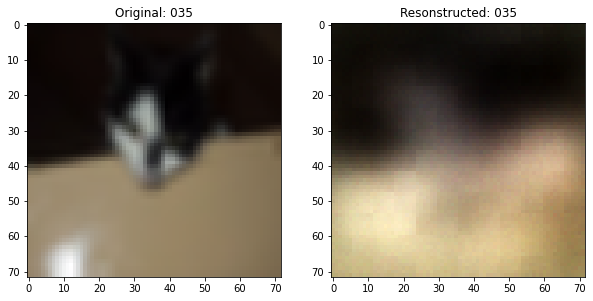

79/79 [==============================] - 4s 47ms/step - loss: 0.0111 - mae: 0.0770 - val_loss: 0.0145 - val_mae: 0.0873 - lr: 5.0000e-04
Epoch 37/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0111 - mae: 0.0770 - val_loss: 0.0143 - val_mae: 0.0869 - lr: 5.0000e-04
Epoch 38/100
79/79 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0765
Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
79/79 [==============================] - 3s 43ms/step - loss: 0.0110 - mae: 0.0765 - val_loss: 0.0142 - val_mae: 0.0863 - lr: 5.0000e-04
Epoch 39/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0108 - mae: 0.0757 - val_loss: 0.0140 - val_mae: 0.0853 - lr: 2.5000e-04
Epoch 40/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0108 - mae: 0.0757 - val_loss: 0.0140 - val_mae: 0.0857 - lr: 2.5000e-04
Epoch 41/100
79/79 [==============================] - ETA: 0s - loss: 0.0108 - mae: 0.0757
Index selected

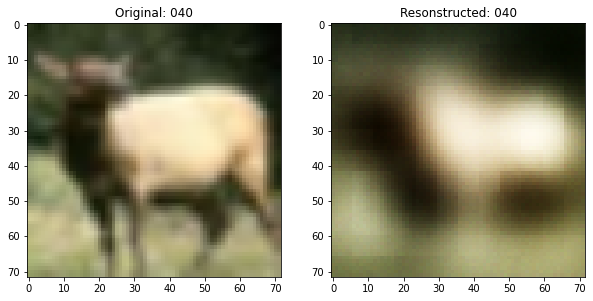

79/79 [==============================] - 4s 46ms/step - loss: 0.0108 - mae: 0.0757 - val_loss: 0.0140 - val_mae: 0.0854 - lr: 2.5000e-04
Epoch 42/100
79/79 [==============================] - ETA: 0s - loss: 0.0107 - mae: 0.0754
Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
79/79 [==============================] - 3s 43ms/step - loss: 0.0107 - mae: 0.0754 - val_loss: 0.0140 - val_mae: 0.0854 - lr: 2.5000e-04
Epoch 43/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0106 - mae: 0.0750 - val_loss: 0.0139 - val_mae: 0.0849 - lr: 1.2500e-04
Epoch 44/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0106 - mae: 0.0750 - val_loss: 0.0138 - val_mae: 0.0849 - lr: 1.2500e-04
Epoch 45/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0106 - mae: 0.0749 - val_loss: 0.0139 - val_mae: 0.0850 - lr: 1.2500e-04
Epoch 46/100
79/79 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0749
Index selected

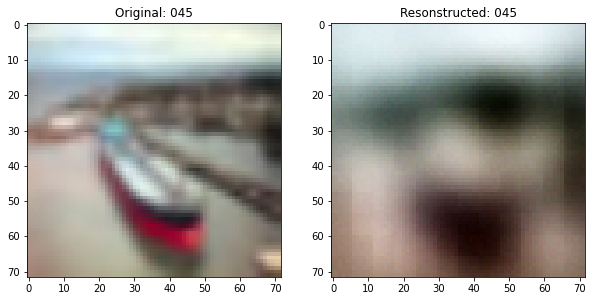

79/79 [==============================] - 4s 47ms/step - loss: 0.0106 - mae: 0.0749 - val_loss: 0.0138 - val_mae: 0.0848 - lr: 1.2500e-04
Epoch 47/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0106 - mae: 0.0749 - val_loss: 0.0139 - val_mae: 0.0848 - lr: 1.2500e-04
Epoch 48/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0138 - val_mae: 0.0848 - lr: 1.2500e-04
Epoch 49/100
79/79 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0747
Epoch 00049: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0138 - val_mae: 0.0848 - lr: 1.2500e-04
Epoch 50/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0137 - val_mae: 0.0844 - lr: 6.2500e-05
Epoch 51/100
79/79 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0746
Index selected:

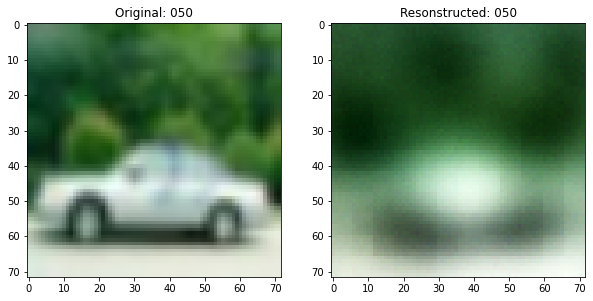

79/79 [==============================] - 4s 47ms/step - loss: 0.0105 - mae: 0.0746 - val_loss: 0.0138 - val_mae: 0.0846 - lr: 6.2500e-05
Epoch 52/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0745 - val_loss: 0.0138 - val_mae: 0.0847 - lr: 6.2500e-05
Epoch 53/100
79/79 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0746
Epoch 00053: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0746 - val_loss: 0.0138 - val_mae: 0.0848 - lr: 6.2500e-05
Epoch 54/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0745 - val_loss: 0.0138 - val_mae: 0.0845 - lr: 3.1250e-05
Epoch 55/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0137 - val_mae: 0.0845 - lr: 3.1250e-05
Epoch 56/100
78/79 [============================>.] - ETA: 0s - loss: 0.0105 - mae: 0.0747
Epoch 00056: R

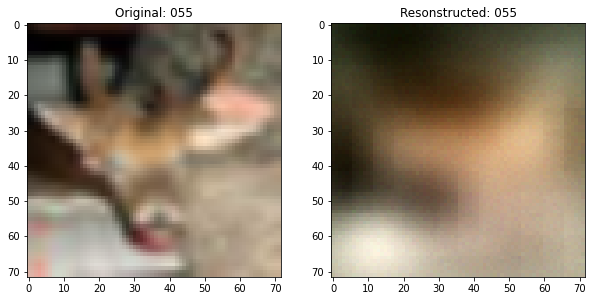

79/79 [==============================] - 4s 47ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0139 - val_mae: 0.0847 - lr: 3.1250e-05
Epoch 57/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0138 - val_mae: 0.0846 - lr: 1.5625e-05
Epoch 58/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0105 - mae: 0.0747 - val_loss: 0.0138 - val_mae: 0.0847 - lr: 1.5625e-05
Epoch 59/100
79/79 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0746
Epoch 00059: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - mae: 0.0746 - val_loss: 0.0139 - val_mae: 0.0849 - lr: 1.5625e-05
Epoch 60/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0106 - mae: 0.0750 - val_loss: 0.0138 - val_mae: 0.0849 - lr: 7.8125e-06
Epoch 61/100
79/79 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0748
Index selected

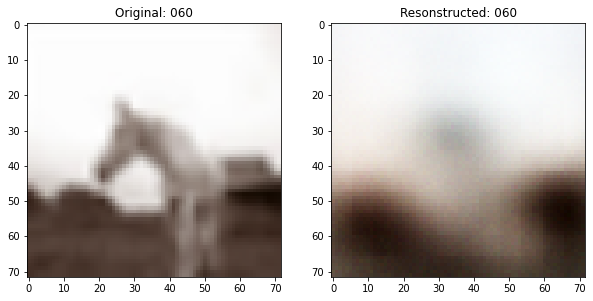

79/79 [==============================] - 4s 47ms/step - loss: 0.0106 - mae: 0.0748 - val_loss: 0.0139 - val_mae: 0.0851 - lr: 7.8125e-06
Epoch 62/100
79/79 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0751
Epoch 00062: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
79/79 [==============================] - 3s 43ms/step - loss: 0.0106 - mae: 0.0751 - val_loss: 0.0139 - val_mae: 0.0852 - lr: 7.8125e-06
Epoch 63/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0107 - mae: 0.0753 - val_loss: 0.0140 - val_mae: 0.0854 - lr: 3.9063e-06
Epoch 64/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0107 - mae: 0.0754 - val_loss: 0.0140 - val_mae: 0.0856 - lr: 3.9063e-06
Epoch 65/100
79/79 [==============================] - ETA: 0s - loss: 0.0107 - mae: 0.0756
Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
79/79 [==============================] - 3s 43ms/step - loss: 0.0107 - mae: 0.0756 

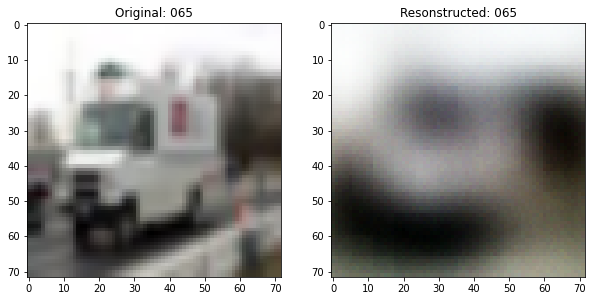

79/79 [==============================] - 4s 47ms/step - loss: 0.0108 - mae: 0.0759 - val_loss: 0.0141 - val_mae: 0.0862 - lr: 1.9531e-06
Epoch 67/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0108 - mae: 0.0760 - val_loss: 0.0142 - val_mae: 0.0865 - lr: 1.9531e-06
Epoch 68/100
79/79 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0761
Epoch 00068: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
79/79 [==============================] - 3s 43ms/step - loss: 0.0109 - mae: 0.0761 - val_loss: 0.0143 - val_mae: 0.0867 - lr: 1.9531e-06
Epoch 69/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0110 - mae: 0.0766 - val_loss: 0.0144 - val_mae: 0.0871 - lr: 9.7656e-07
Epoch 70/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0111 - mae: 0.0770 - val_loss: 0.0145 - val_mae: 0.0876 - lr: 9.7656e-07
Epoch 71/100
78/79 [============================>.] - ETA: 0s - loss: 0.0112 - mae: 0.0776
Epoch 00071: R

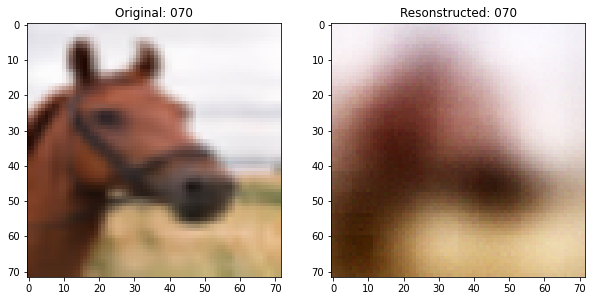

79/79 [==============================] - 4s 49ms/step - loss: 0.0112 - mae: 0.0776 - val_loss: 0.0146 - val_mae: 0.0880 - lr: 9.7656e-07
Epoch 72/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0113 - mae: 0.0780 - val_loss: 0.0147 - val_mae: 0.0886 - lr: 4.8828e-07
Epoch 73/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0114 - mae: 0.0785 - val_loss: 0.0148 - val_mae: 0.0891 - lr: 4.8828e-07
Epoch 74/100
78/79 [============================>.] - ETA: 0s - loss: 0.0116 - mae: 0.0792
Epoch 00074: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
79/79 [==============================] - 3s 43ms/step - loss: 0.0116 - mae: 0.0792 - val_loss: 0.0150 - val_mae: 0.0899 - lr: 4.8828e-07
Epoch 75/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0118 - mae: 0.0801 - val_loss: 0.0152 - val_mae: 0.0907 - lr: 2.4414e-07
Epoch 76/100
79/79 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0807
Index selecte

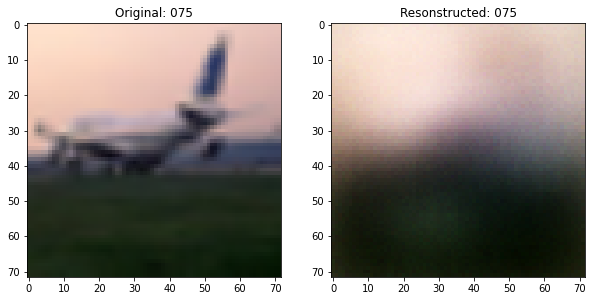

79/79 [==============================] - 4s 47ms/step - loss: 0.0119 - mae: 0.0807 - val_loss: 0.0154 - val_mae: 0.0916 - lr: 2.4414e-07
Epoch 77/100
79/79 [==============================] - ETA: 0s - loss: 0.0122 - mae: 0.0817
Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
79/79 [==============================] - 3s 43ms/step - loss: 0.0122 - mae: 0.0817 - val_loss: 0.0156 - val_mae: 0.0924 - lr: 2.4414e-07
Epoch 78/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0124 - mae: 0.0827 - val_loss: 0.0159 - val_mae: 0.0936 - lr: 1.2207e-07
Epoch 79/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0127 - mae: 0.0840 - val_loss: 0.0162 - val_mae: 0.0948 - lr: 1.2207e-07
Epoch 80/100
79/79 [==============================] - ETA: 0s - loss: 0.0129 - mae: 0.0849
Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
79/79 [==============================] - 3s 44ms/step - loss: 0.0129 - mae: 0.0849 

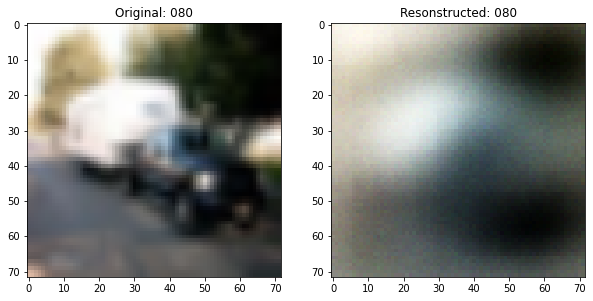

79/79 [==============================] - 4s 47ms/step - loss: 0.0133 - mae: 0.0864 - val_loss: 0.0170 - val_mae: 0.0977 - lr: 6.1035e-08
Epoch 82/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0138 - mae: 0.0882 - val_loss: 0.0174 - val_mae: 0.0992 - lr: 6.1035e-08
Epoch 83/100
79/79 [==============================] - ETA: 0s - loss: 0.0142 - mae: 0.0899
Epoch 00083: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
79/79 [==============================] - 3s 43ms/step - loss: 0.0142 - mae: 0.0899 - val_loss: 0.0178 - val_mae: 0.1009 - lr: 6.1035e-08
Epoch 84/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0146 - mae: 0.0915 - val_loss: 0.0184 - val_mae: 0.1030 - lr: 3.0518e-08
Epoch 85/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0152 - mae: 0.0937 - val_loss: 0.0190 - val_mae: 0.1050 - lr: 3.0518e-08
Epoch 86/100
79/79 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0957
Epoch 00086: R

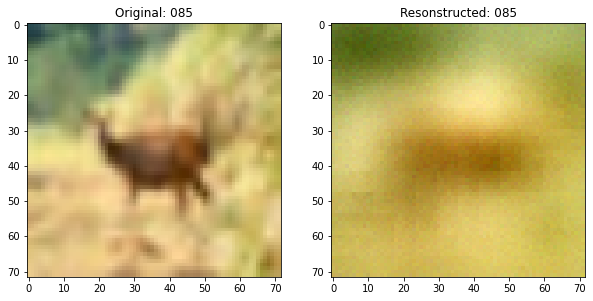

79/79 [==============================] - 4s 47ms/step - loss: 0.0157 - mae: 0.0957 - val_loss: 0.0197 - val_mae: 0.1073 - lr: 3.0518e-08
Epoch 87/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0164 - mae: 0.0983 - val_loss: 0.0204 - val_mae: 0.1099 - lr: 1.5259e-08
Epoch 88/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0172 - mae: 0.1011 - val_loss: 0.0212 - val_mae: 0.1125 - lr: 1.5259e-08
Epoch 89/100
79/79 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.1036
Epoch 00089: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.
79/79 [==============================] - 3s 43ms/step - loss: 0.0179 - mae: 0.1036 - val_loss: 0.0221 - val_mae: 0.1154 - lr: 1.5259e-08
Epoch 90/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0188 - mae: 0.1068 - val_loss: 0.0231 - val_mae: 0.1185 - lr: 7.6294e-09
Epoch 91/100
79/79 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.1102
Index selected

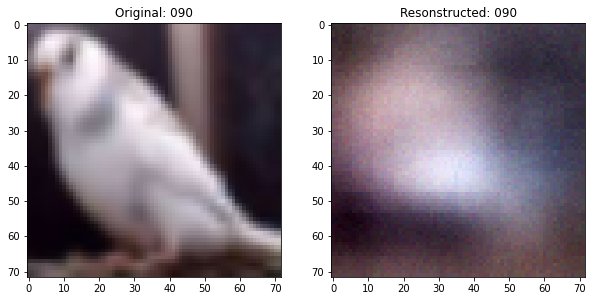

79/79 [==============================] - 4s 46ms/step - loss: 0.0199 - mae: 0.1102 - val_loss: 0.0242 - val_mae: 0.1218 - lr: 7.6294e-09
Epoch 92/100
79/79 [==============================] - ETA: 0s - loss: 0.0209 - mae: 0.1136
Epoch 00092: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
79/79 [==============================] - 3s 43ms/step - loss: 0.0209 - mae: 0.1136 - val_loss: 0.0252 - val_mae: 0.1248 - lr: 7.6294e-09
Epoch 93/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0220 - mae: 0.1171 - val_loss: 0.0264 - val_mae: 0.1283 - lr: 3.8147e-09
Epoch 94/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0233 - mae: 0.1208 - val_loss: 0.0276 - val_mae: 0.1319 - lr: 3.8147e-09
Epoch 95/100
78/79 [============================>.] - ETA: 0s - loss: 0.0245 - mae: 0.1244
Epoch 00095: ReduceLROnPlateau reducing learning rate to 1.907348723406699e-09.
79/79 [==============================] - 3s 43ms/step - loss: 0.0245 - mae: 0.1244 -

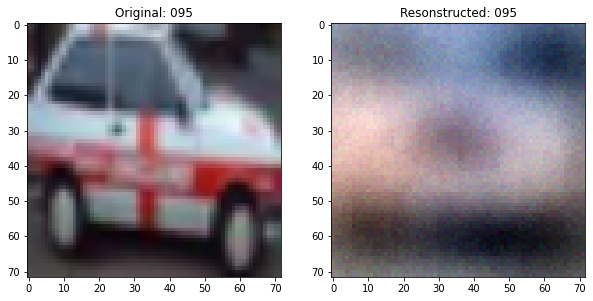

79/79 [==============================] - 4s 47ms/step - loss: 0.0258 - mae: 0.1282 - val_loss: 0.0302 - val_mae: 0.1390 - lr: 1.9073e-09
Epoch 97/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0272 - mae: 0.1321 - val_loss: 0.0315 - val_mae: 0.1424 - lr: 1.9073e-09
Epoch 98/100
79/79 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.1357
Epoch 00098: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
79/79 [==============================] - 3s 43ms/step - loss: 0.0285 - mae: 0.1357 - val_loss: 0.0329 - val_mae: 0.1458 - lr: 1.9073e-09
Epoch 99/100
79/79 [==============================] - 3s 43ms/step - loss: 0.0299 - mae: 0.1393 - val_loss: 0.0342 - val_mae: 0.1493 - lr: 9.5367e-10
Epoch 100/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0313 - mae: 0.1430 - val_loss: 0.0355 - val_mae: 0.1524 - lr: 9.5367e-10


In [22]:
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

In [23]:
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

20/20 [==============================] - 0s 14ms/step - loss: 0.0356 - mae: 0.1526
Loss: 0.04
MAE: 0.15


# Downstream Task

Use the following layers for the downstream task.

In [24]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing)
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ], name="linear_probe_model"
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches (Patches)           (None, 144, 108)          0         
                                                                 
 patch_encoder (PatchEncoder  (None, 144, 64)          16300     
 )                                                               
                                                                 
 mae_encoder (Functional)    (None, None, 64)          166528    
                                                                 
 batch_normalization (BatchN  (None, 144, 64)          256       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                

In [25]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [26]:
linear_probe_epochs = 50
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)
scheduled_lrs = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1, decay_steps=steps
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
79/79 [==============================] - 6s 50ms/step - loss: 2.1400 - accuracy: 0.2192 - val_loss: 2.0280 - val_accuracy: 0.2731
Epoch 2/50
79/79 [==============================] - 4s 45ms/step - loss: 2.0155 - accuracy: 0.2715 - val_loss: 1.9758 - val_accuracy: 0.3006
Epoch 3/50
79/79 [==============================] - 4s 45ms/step - loss: 1.9819 - accuracy: 0.2858 - val_loss: 1.9545 - val_accuracy: 0.3089
Epoch 4/50
79/79 [==============================] - 4s 46ms/step - loss: 1.9680 - accuracy: 0.2937 - val_loss: 1.9408 - val_accuracy: 0.3126
Epoch 5/50
79/79 [==============================] - 4s 45ms/step - loss: 1.9584 - accuracy: 0.2965 - val_loss: 1.9302 - val_accuracy: 0.3183
Epoch 6/50
79/79 [==============================] - 4s 45ms/step - loss: 1.9560 - accuracy: 0.2977 - val_loss: 1.9250 - val_accuracy: 0.3220
Epoch 7/50
79/79 [==============================] - 4s 45ms/step - loss: 1.9373 - accuracy: 0.3083 - val_loss: 1.9159 - val_accuracy: 0.3257
Epoch 8/50
79

In [27]:
downstream_model.save(f"linear_probe_{timestamp}")

2021-11-18 16:17:53.433595: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: linear_probe_211118-160842/assets


INFO:tensorflow:Assets written to: linear_probe_211118-160842/assets
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## TODO

* Follow the hyperparameters more closely and adjust them w.r.t CIFAR-10.